In [1]:
import csv
from collections import defaultdict
import pandas as pd
import numpy as np
import sqlite3 as sql
import time
import requests
import json
import logging
from random import randint
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import scipy
from statistics import mean

DB_NAME = 'main.db'


NEW_BUILD = {"N": 0,
             "Y": 1}

HOUSE_TYPE ={"D":1,
             "S":2,
             "O":9,
             "T":3,
             "F":4}

CRIME_SCORE = { "bicycle-theft":4,
                "burglary":10,
               "criminal-damage-arson":9,
               "drugs":6,
               "other-theft":8,
               "possession-of-weapons:":10,
               "robbery":10,
               "shoplifting":4,
               "theft-from-the-person" :7,
               "vehicle-crime" : 10,
               "violent-crime": 10               
              }



broadband_table = """CREATE TABLE IF NOT EXISTS broadband_table (
                               admin_ward_code TEXT  NOT NULL,
                               broadband_speed int,
                               FOREIGN KEY (admin_ward_code) REFERENCES administration_ward(admin_ward_code)
                                ); """


crime_table  = """
            CREATE TABLE IF NOT EXISTS crime_table (
            postcode TEXT NOT NULL,
            crime_score int,
            PRIMARY KEY (postcode)
            );
                """


main_properties_table = """

            CREATE TABLE IF NOT EXISTS main_table_properties(
              id TEXT,
              postcode TEXT,
              admin_ward_code TEXT,
              PRIMARY KEY (id),
              FOREIGN KEY (postcode) REFERENCES crime_table(postcode),
              FOREIGN KEY (admin_ward_code) REFERENCES administration_ward(admin_ward_code)
            );
            """


house_information_table = """
                    CREATE TABLE IF NOT EXISTS house_information(
                      id TEXT,
                      admin_ward_code TEXT,
                      price int,
                      build_type int,
                      new_build int,
                      FOREIGN KEY (id) REFERENCES main_table_properties(id),
                      FOREIGN KEY (admin_ward_code) REFERENCES administration_ward(admin_ward_code)

                    );
                    """
admin_ward_table = """ CREATE TABLE IF NOT EXISTS administration_ward(
                    admin_ward_code TEXT, 
                    ward_name TEXT,
                    PRIMARY KEY(admin_ward_code)
                    );

                        """



houses = pd.read_csv('houses-both-counties-april-2019.csv')
broadband_performance = pd.read_csv('broadband_speed.csv')

In [2]:
def create_connection(db_file):
    conn = None
    try:
        conn = sql.connect(db_file)
        return conn
    except Error as e:
        print("dunno", e)

    return conn

In [3]:
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

In [4]:
def get_postcode_info_api(postcode):
    try: 
        api_string_req = 'http://127.0.0.1:8000/postcodes/{code}'.format(code = postcode)
        r = requests.get(api_string_req).json()
        return r['result']
    except Exception as e:
        return None


In [5]:
def create_sql_tables():
    conn = create_connection(DB_NAME)
    if conn is not None:
        create_table(conn, broadband_table)
        create_table(conn, crime_table)
        create_table(conn, main_properties_table)
        create_table(conn, house_information_table)
        create_table(conn, admin_ward_table)

    else:
        print("Error! cannot create the database connection.")

In [6]:
def get_crime_external_api(lat,long,postcode,cursor):
    try:
        sql_statement = """SELECT crime_score from crime_table WHERE postcode == {p} """.format(p = "'{}'".format(postcode))
        cursor.execute(sql_statement)
        crime_score = cursor.fetchall()
        if len(crime_score) == 0:
            raise Exception("crime rate not in database, external api must be used.")
        else:
            return crime_score
    except Exception as e:
        print(e)
        pass
    crime_score = 0
    for month in range(1,13):
        api_string_req = 'https://data.police.uk/api/crimes-at-location?date=2018-{month}&lat={lat}&lng={long}'.format(lat=lat,long=long, month= month)
        try:
            r = requests.get(api_string_req).json()
            for crime_data in r:
                try:
                    category = crime_data['category']
                    crime_score += CRIME_SCORE[category]
                except KeyError:
                    continue
        except Exception as e:
            print(e)
            continue
    try:
        sql_statement_crime = """ INSERT INTO crime_table
        (postcode,crime_score) 
        VALUES ({pc}, {cr})""".format(
            pc = '"{}"'.format(postcode), 
            cr = crime_score)
   
        cursor.execute(sql_statement_crime)
    except:
        pass
    return crime_score

In [7]:
def get_df_z_score(main_df):
    z_score_df = main_df[['price', 'crime_score', 'broadband_speed']].copy()
    return stats.zscore(z_score_df)

In [8]:
def get_broadband_performance(admin_ward_code,cursor):
    broadband_speed = 0
    try:
        sql_statement = """SELECT broadband_speed FROM broadband_table WHERE admin_ward_code == {awc}""".format(awc = "'{}'".format(admin_ward_code))
        cursor.execute(sql_statement)
        broadband_speed = cursor.fetchall()
        if len(broadband_speed) == 0:
            raise Exception('Broadband speed not in database must be searched')
    except Exception as e:
        print(e)
        for index,data in broadband_performance.iterrows():
            if data['id'] == admin_ward_code:
                broadband_speed = data['average']
                break
    try:
        insert_broadband = """INSERT INTO broadband_table(admin_ward_code, broadband_speed) VALUES ({admin_ward_code},{speed})""".format(admin_ward_code = "'{}'".format(admin_ward_code), speed = broadband_speed)
        print(insert_broadband)
        cursor.execute(insert_broadband)
    except:
        pass

In [9]:
def database_ward_insert(admin_ward_code, admin_district,cur):
    try:
        sql_statement = """INSERT INTO administration_ward(admin_ward_code, ward_name)
                        VALUES({awc}, {ad})
                        """.format(awc = "'{}'".format(admin_ward_code), ad = "'{}'".format(admin_district))
        cur.execute(sql_statement)
    except Exception as e:
        print(e)
        return

In [10]:
def database_populate(sql_connection,csv_houses):
    cur = sql_connection.cursor()
    command = input("Heavy work ahead. hit Enter to continue...")
    times = 0
    cur = sql_connection.cursor()
    for index,data in csv_houses.iterrows():
        print(times)
        times+=1
        house_postcode = data['postcode']
        unique_id = data['unique_id']
        house_price = data['price_paid']
        additional_data = get_postcode_info_api(house_postcode)
        print(additional_data)
        if additional_data is None:
            continue
        admin_district = additional_data['admin_district']
        new_build = NEW_BUILD[data['new_build']]
        house_type = HOUSE_TYPE[data['property_type']]
        admin_ward_code = additional_data['codes']['admin_ward']
        longitude = additional_data['longitude']
        latitude = additional_data['latitude']
        
        database_ward_insert(admin_ward_code, admin_district,cur)
        
        get_crime_external_api(latitude,longitude,house_postcode,cur)
        
        get_broadband_performance(admin_ward_code,cur)
    
        main_sql_statement = """ INSERT INTO main_table_properties
        (id,postcode,admin_ward_code) 
        VALUES ({id}, {pc}, {aw})""".format(
            aw = '"{}"'.format(admin_ward_code), 
            pc = '"{}"'.format(house_postcode), 
            id = '"{}"'.format(unique_id)
        )
        
        additional_info_sql = """ INSERT INTO house_information
        (id,admin_ward_code,price,build_type,new_build) 
        VALUES ({id}, {aw}, {pc}, {bt}, {nb})""".format(
            id = '"{}"'.format(unique_id), 
            aw = '"{}"'.format(admin_ward_code), 
            bt = house_type,
            nb = new_build,
            pc = house_price
        )
        
        try:
            
            cur.execute(main_sql_statement)
            cur.execute(additional_info_sql)
        except:
            continue
        

In [11]:
def weighted_z_based_recommandation_system():
    database_connection = create_connection('main.db')
    cur = database_connection.cursor()
    pd.set_option("display.precision", 15)
    pd.set_option('display.float_format', '{:.5f}'.format)

    print("Select a level of importance from 1-10 for the following")
    crime_rate = int(input("Crime Rate:"))
    price = int(input("House Price:"))
    broadband = int(input("Broadband Speed:"))
    added_up = sum([crime_rate,price,broadband])
    user_crime_score = crime_rate / added_up
    user_price_score = price / added_up
    user_broadband_score = broadband / added_up
    sql_get_data_query = """
                    SELECT main_table_properties.id,main_table_properties.admin_ward_code,main_table_properties.postcode,price, broadband_speed, crime_score FROM main_table_properties
                    INNER JOIN house_information ON house_information.id = main_table_properties.id
                    INNER JOIN broadband_table ON broadband_table.admin_ward_code = main_table_properties.admin_ward_code
                    INNER JOIN crime_table ON crime_table.postcode = main_table_properties.postcode
            """
    
    
    df = pd.read_sql_query(sql_get_data_query, database_connection)
    df["final_score"] = np.nan
    
    z_score = get_df_z_score(df)
    for index,data in df.iterrows():
        df.at[index,'final_score'] = z_score[index][0] * user_price_score +  z_score[index][1] * user_crime_score + (z_score[index][2] * -1) * user_broadband_score
    results = df.sort_values('final_score', ascending=True, kind="quicksort")
    print("There are the top 10 houses sold which fit your criteria best")
    print(results.head(10))

    best_locations = {}

    #check which location comes up the most out of the top 10 locations
    max_top = 20
    j = 0
    for index,data in results.iterrows():
        j+=1
        location = data["admin_ward_code"]
        if location in best_locations:
            best_locations[location] +=1
        else:
            best_locations[location] = 1
        if j == max_top:
            break
    locations_list_placeholder = []
    for key,value in best_locations.items():
        if value not in locations_list_placeholder:
            locations_list_placeholder.append(key)
    
    sql="SELECT ward_name FROM administration_ward WHERE admin_ward_code in ({seq})".format(
    seq=','.join(['?']*len(locations_list_placeholder)))

    cur.execute(sql,locations_list_placeholder)
    heaven = cur.fetchall()
    print("Best locations based on your criteria are:")
    for value in set(heaven):
        print(value[0])
    return None

In [48]:
# precentile_based_non_weighted()
# weighted_z_based_recommandation_system()

Fetching best locations...
Coalville North
Whitwick
Mallory
                                        id admin_ward_code  postcode   price  \
255   8F1B26BD-DE2E-53DB-E053-6C04A8C03649       E05010112  LE67 2HG  125000   
288   87E1551E-540B-6405-E053-6C04A8C0B2EE       E05010099  LE67 5PH  131250   
435   87E1551E-E51D-6405-E053-6C04A8C0B2EE       E05005481   LE9 8HA   85000   
429   8A78B2AF-BD8D-5CB0-E053-6B04A8C0F504       E05005481   LE9 8DE   93000   
571   8A78B2B0-2937-5CB0-E053-6B04A8C0F504       E05007489  CV10 7BL  128500   
...                                    ...             ...       ...     ...   
478   8F1B26BE-568D-53DB-E053-6C04A8C03649       E05007463   B46 3EU  535000   
525   8A78B2B0-2997-5CB0-E053-6B04A8C0F504       E05010192   B95 5BS  675000   
1019  87E1551E-B126-6405-E053-6C04A8C0B2EE       E05010198  CV47 2AE  785000   
524   87E1551E-B03F-6405-E053-6C04A8C0B2EE       E05010207   B94 5SJ  315000   
1043  8F1B26BE-57F6-53DB-E053-6C04A8C03649       E05007466  

In [12]:
def precentile_based_non_weighted():
    database_connection = create_connection('main.db')
    cur = database_connection.cursor()
    pd.set_option("display.precision", 15)
    pd.set_option('display.float_format', '{:.5f}'.format)
    sql_get_data_query = """
                    SELECT main_table_properties.id,main_table_properties.admin_ward_code,main_table_properties.postcode,price, broadband_speed, crime_score FROM main_table_properties
                    INNER JOIN house_information ON house_information.id = main_table_properties.id
                    INNER JOIN broadband_table ON broadband_table.admin_ward_code = main_table_properties.admin_ward_code
                    INNER JOIN crime_table ON crime_table.postcode = main_table_properties.postcode
            """

    df = pd.read_sql_query(sql_get_data_query, database_connection)
    df["final_score"] = np.nan
    
    for index,data in df.iterrows():
        broadband_speed = data['broadband_speed']
        house_price = data['price']
        crime_score = data['crime_score']
        broadband_precentile = round(stats.percentileofscore(df['broadband_speed'],broadband_speed, kind ='weak') / 10,2)
        price_precentile = 10 - round(stats.percentileofscore(df['price'],house_price, kind = 'weak') / 10,2)
        crime_precentile = 10 - round(stats.percentileofscore(df['crime_score'],crime_score, kind = 'weak') / 10,2)
        score = mean([broadband_precentile,price_precentile,crime_precentile])
        final_score = float("%.1f" % score)
        df.at[index,'final_score'] = final_score    
    best_locations = {}
    new_data_frame = pd.DataFrame()
    results = df.sort_values('final_score', ascending=False, kind="quicksort")
    print("Fetching best locations...")
    amount = 0
    my_dict = defaultdict(int)
    for index,data in results.iterrows():
        if amount == 20:
            break
        amount +=1
        postcode = data['postcode'].replace(" ", "")
        api_string_req = 'http://127.0.0.1:8000/postcodes/{code}'.format(code = postcode)
        r = requests.get(api_string_req).json()
        location = r['result']['ced']
        my_dict[location] += 1
    i = 0
    for key,value in my_dict.items():
        print(key)
        i+=1
        if i == 3:
            break
    print(results)

In [15]:
con = sql.connect('main.db')
pd.set_option('display.float_format', lambda x: '%.0f' % x)
sql_df_query = """   SELECT main_table_properties.id, price, broadband_speed, crime_score  ,build_type, new_build FROM main_table_properties
                    INNER JOIN house_information ON house_information.id = main_table_properties.id
                    INNER JOIN broadband_table ON broadband_table.admin_ward_code = main_table_properties.admin_ward_code
                    INNER JOIN crime_table ON crime_table.postcode = main_table_properties.postcode """

df = pd.read_sql_query(sql_df_query, con)
df.describe()

,price,broadband_speed,crime_score,build_type,new_build
count,1084,1084,1084,1084,1084
mean,257140,47,55,2,0
std,153117,15,67,1,0
min,58000,17,0,1,0
25%,170000,31,10,1,0
50%,220000,50,30,2,0
75%,300000,59,75,3,0
max,1415000,75,430,4,1


In [16]:
def get_required_data():
    with sql.connect(DB_NAME) as con:
            database_populate(con,houses)

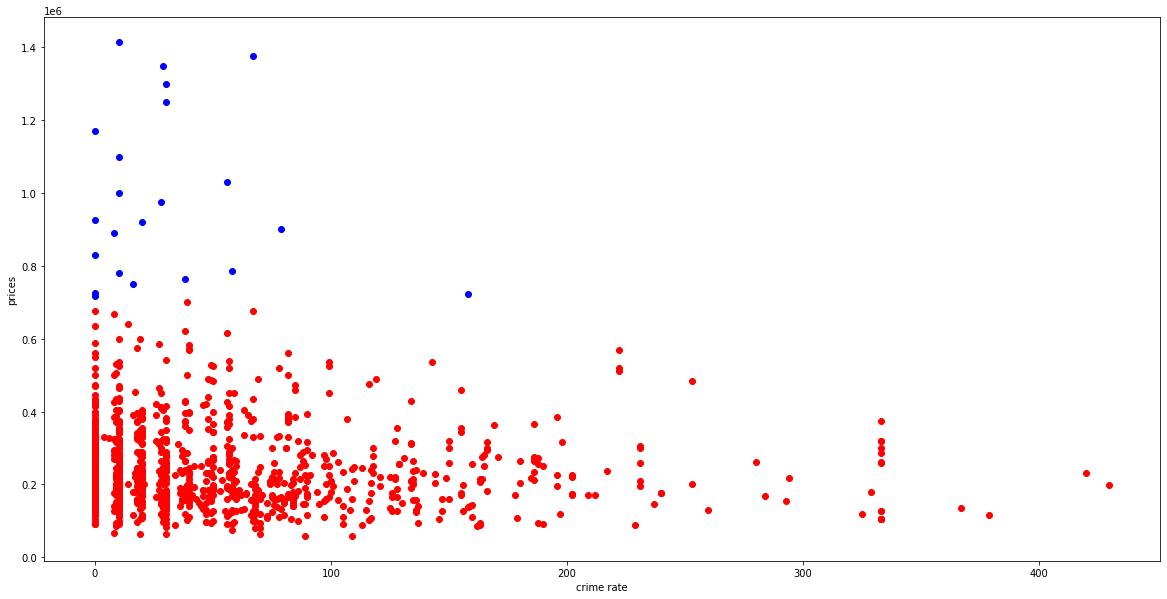

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

outliers=[]
def find_outlier(data):
    
    threshold=3
    mean_1 = np.mean(data['price'])
    std_1 =np.std(data['price'])
    
    
    for y in data['price']:
        z_score= (y- mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

outliers = find_outlier(df)
min_threshold = min(outliers)
max_threshold = max(outliers)

b = df['price']
a = df['crime_score']
values = [df['price'],df['crime_score']]
matplotlib.rc('figure', figsize=(20, 10))
for x,y in zip(a,b):
    color = 'blue'  # non-outlier color
    if not min_threshold <= y <= max_threshold:  # condition for being an outlier
        color = 'red'  # outlier color
    plt.scatter(x,y, color=color)

plt.xlabel('crime rate')
plt.ylabel('prices')
plt.show()


In [28]:
# create_sql_tables()
# get_required_data()

<AxesSubplot:>

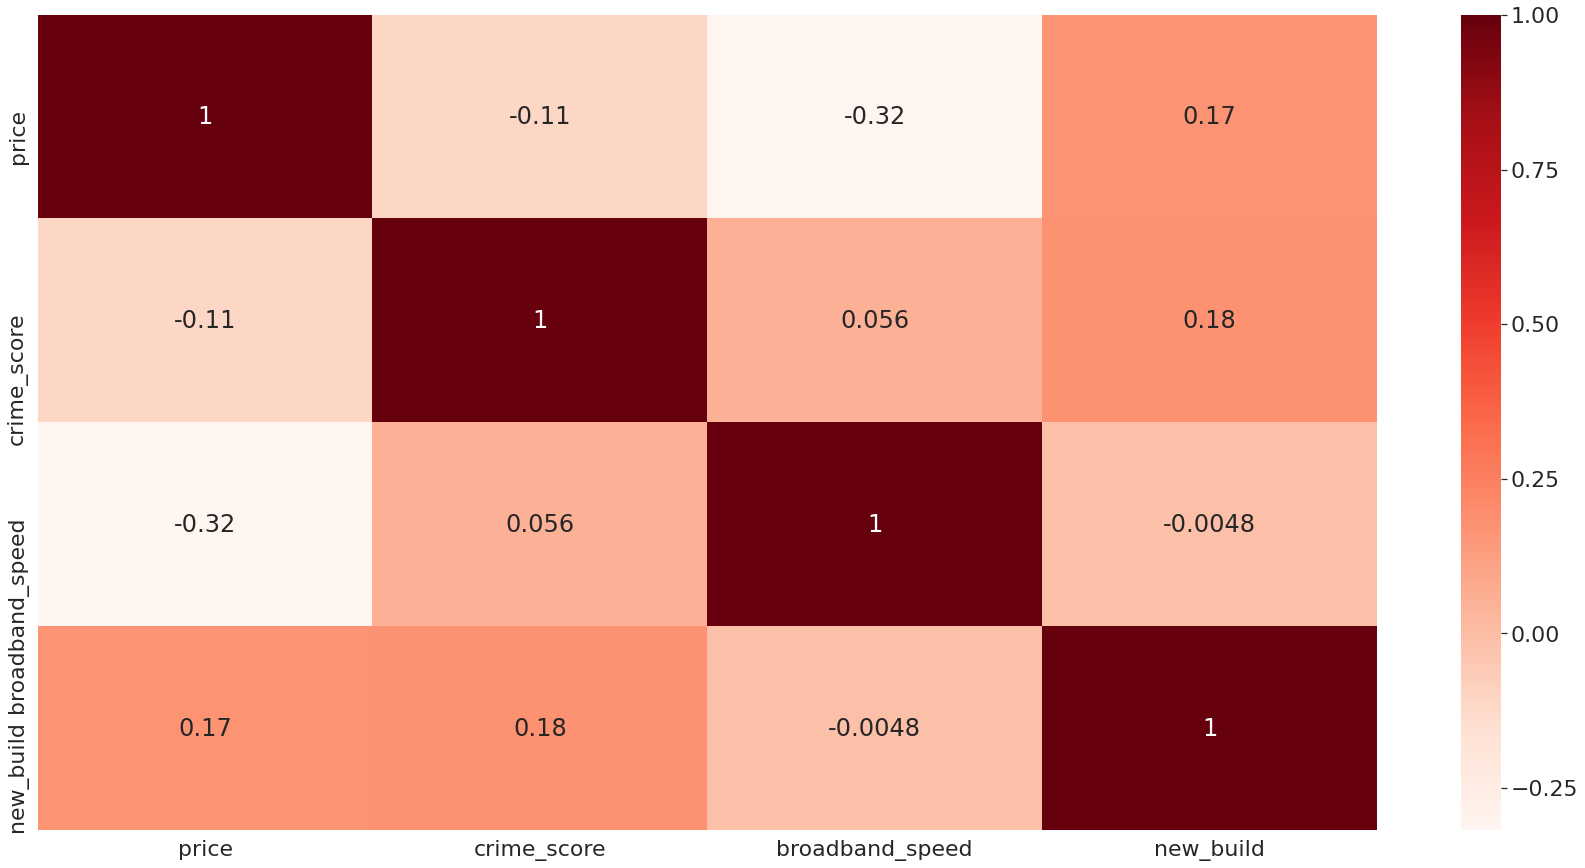

In [19]:
sns.set(rc={'figure.figsize':(30,15)})
sns.set(font_scale=2)
sns.heatmap(df[['price','crime_score','broadband_speed','new_build']].corr(), annot=True, cmap = 'Reds')


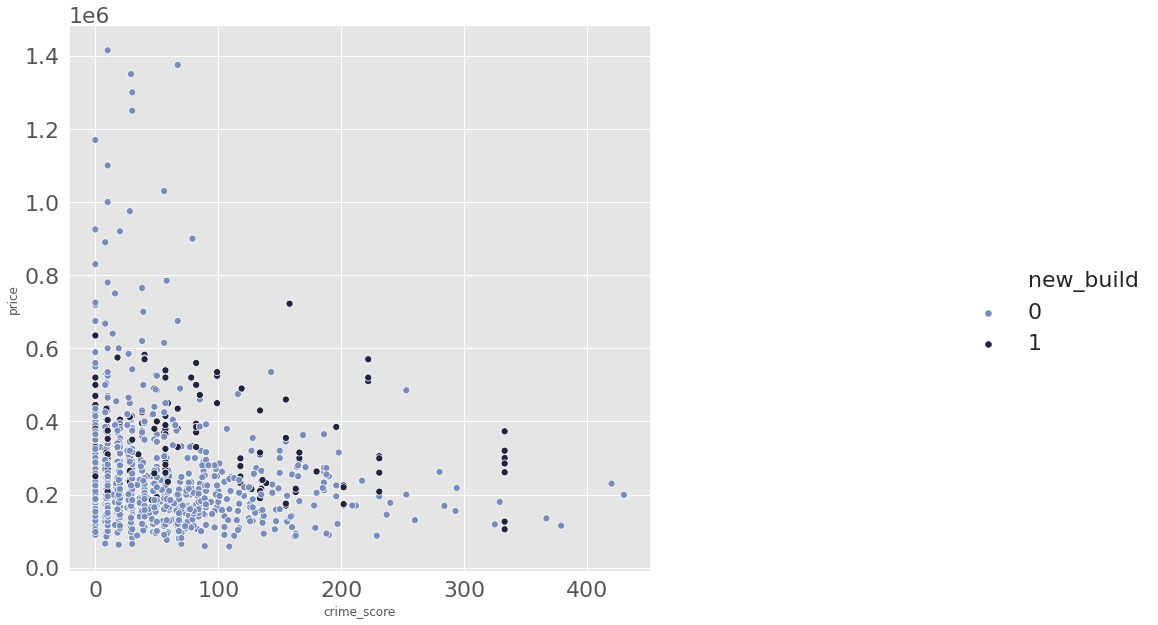

In [25]:
price = df['price']
g = sns.relplot(x="crime_score", y="price", hue="new_build", palette="ch:r=-.1,l=.55", data=df,s=50);
g.fig.set_size_inches(20,10)


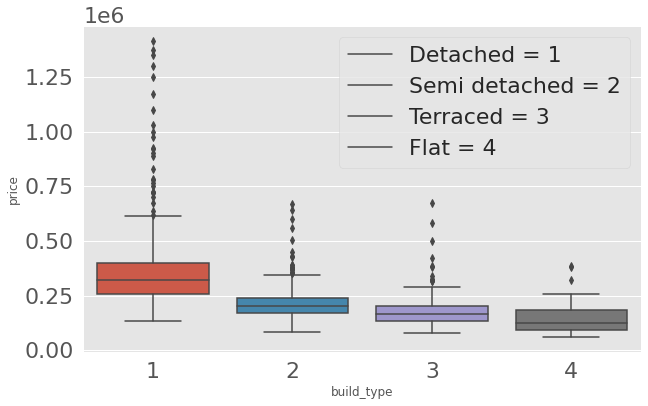

In [22]:
legend=["Detached = 1","Semi detached = 2", "Terraced = 3", "Flat = 4"]
ax = sns.boxplot(y='price',x='build_type',data=df)
ax.legend(legend)


In [26]:
basic_recommandation_system()

NameError: name 'basic_recommandation_system' is not defined

In [27]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
def multiple_regression(df):
    X = df[['crime_score','new_build','broadband_speed']]
    Y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=101)
    model = LinearRegression()
    model.fit(X_train,y_train)
    print(model.intercept_)
    coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
    print(coeff_parameter)
    
    predictions = model.predict(X_test)
    sns.regplot(y_test,predictions)
    X_train_Sm= sm.add_constant(X_train)
    ls=sm.OLS(y_train,X_train_Sm).fit()
    print(ls.summary())
    # comment lines below to see the regression model regplot
    residuals = y_test - predictions
    visualizer = ResidualsPlot(model, hist=False, qqplot=True)
    visualizer.fit(X_train, y_train)
#     visualizer.score(X_test, y_test)
    visualizer.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


420612.56803385995
                 Coefficient
crime_score             -314
new_build              82672
broadband_speed        -3485
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     51.00
Date:                Sat, 05 Dec 2020   Prob (F-statistic):           1.36e-29
Time:                        08:20:10   Log-Likelihood:                -8589.7
No. Observations:                 650   AIC:                         1.719e+04
Df Residuals:                     646   BIC:                         1.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025    

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


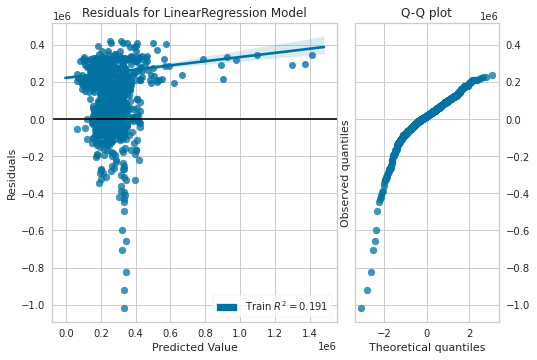

In [28]:
multiple_regression(df)